In [15]:
import pandas as pd
import numpy as np
from plotnine import *

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

In [ ]:
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

In [16]:
train = pd.read_csv("train_data.csv")
test = pd.read_csv("test_data.csv")

In [17]:
# Transform date of sale into sale year, then calculate the difference between
# when the property was last renovated and when it was sold.
# If it hasn't been renovated, use the date the property was built. 

train['YR_RMDL'] = train['YR_RMDL'].fillna(train['AYB'])
train = train[train.YR_RMDL > 1800.]
train['SALE_YEAR'] = train['SALEDATE'].str[0:4]
train['SALE_YEAR'] = train['SALE_YEAR'].astype('int')
train['YEARS_SINCE_RMDL'] = train['SALE_YEAR'] - train['YR_RMDL']

In [18]:
# Drop all observations where the outcome is missing 
train = train[~train.LN_PRICE.isna()]

# Only houses that are sold
train = train[train.LN_PRICE > 0]

# drop variables not to be used
train.drop(['OBJECTID','SSL','GIS_LAST_MOD_DTTM','SALEDATE','SALE_YEAR', 'YR_RMDL',
            'HEAT', 'HEAT_D','ROOF','ROOF_D','INTWALL','INTWALL_D','STYLE','GRADE',
            'GRADE_D','STRUCT','CNDTN','EXTWALL'],axis=1, inplace=True)

In [19]:
# create dummy variables for the style, type of structure, and condition of the property

train_dv = pd.get_dummies(train, prefix='', prefix_sep='', 
                            columns=['STYLE_D','STRUCT_D','CNDTN_D'])

# drop NAs for remaining columns
train_dv.dropna(inplace=True)

train_dv.head()

,BATHRM,HF_BATHRM,AC,NUM_UNITS,ROOMS,BEDRM,AYB,EYB,STORIES,QUALIFIED,...,Single,Town End,Town Inside,Average,Default,Excellent,Fair,Good,Poor,Very Good
0,3.0,1.0,Y,1.0,9.0,4.0,1939.0,1969,2.0,Q,...,0,0,0,0,0,0,0,0,0,1
1,2.0,1.0,Y,1.0,7.0,3.0,1938.0,1972,2.0,Q,...,1,0,0,0,0,0,0,0,0,1
2,2.0,2.0,Y,1.0,9.0,4.0,1940.0,1980,2.5,U,...,1,0,0,1,0,0,0,0,0,0
3,1.0,1.0,Y,1.0,6.0,3.0,1952.0,1952,2.0,Q,...,0,0,0,1,0,0,0,0,0,0
4,2.0,0.0,N,1.0,11.0,4.0,1885.0,1950,2.0,Q,...,0,0,0,1,0,0,0,0,0,0


In [20]:
# split the data into the dependent variable and the independent variables
# then drop several dummy variable columns that don't appear in the pre-split training data
# to prevent pre-processing errors

train_y = train_dv['LN_PRICE'] # OUTCOME: log selling price (some houses are ridiculuously expensive)
train_X = train_dv.drop(['LN_PRICE', '3.5 Story Unfin', '4.5 Story Fin', 'Default'], axis=1)
train_X.shape

(43501, 45)

In [21]:
# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(),
                                              ['BATHRM','HF_BATHRM','NUM_UNITS','ROOMS',
                                               'BEDRM','STORIES','GBA','BLDG_NUM','KITCHENS',
                                               'FIREPLACES','LANDAREA','YEARS_SINCE_RMDL'])])

# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])

# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['BATHRM',
                                                                          'HF_BATHRM',
                                                                          'NUM_UNITS',
                                                                          'ROOMS',
                                                                          'BEDRM',
                                                                          'STORIES',
                                                                          'GBA',
                                                                          'BLDG_NUM',
                                 

In [22]:
search.best_score_ # Mean out-of-sample (CV) error

-0.3831876344263331

In [23]:
search.best_params_

{'model': KNeighborsRegressor(n_neighbors=25), 'model__n_neighbors': 25}

In [24]:
# follow the same data formatting process of the train data for the pre-split test data

# create YEARS_SINCE_RMDL as the difference between the year of sale and last remodel
test['YR_RMDL'] = test['YR_RMDL'].fillna(test['AYB'])
test = test[test.YR_RMDL > 1800.]
test['SALE_YEAR'] = test['SALEDATE'].str[0:4]
test['SALE_YEAR'] = test['SALE_YEAR'].astype('int')
test['YEARS_SINCE_RMDL'] = test['SALE_YEAR'] - test['YR_RMDL']

# Drop all observations where the outcome is missing 
test = test[~test.LN_PRICE.isna()]

# Only houses that are sold
test = test[test.LN_PRICE > 0]

# drop variables not used in the training data
test.drop(['OBJECTID','SSL','GIS_LAST_MOD_DTTM','SALEDATE','SALE_YEAR', 'YR_RMDL',
            'HEAT', 'HEAT_D','ROOF','ROOF_D','INTWALL','INTWALL_D','STYLE','GRADE',
            'GRADE_D','STRUCT','CNDTN','EXTWALL'],axis=1, inplace=True)

# create relevant dummy variables
test_dv = pd.get_dummies(test, prefix='', prefix_sep='', 
                            columns=['STYLE_D','STRUCT_D','CNDTN_D'])

# drop NAs of relevant columns
test_dv.dropna(inplace=True)

# split into y and X, dropping variables that didn't appear in the pre-split train data
test_y = test_dv['LN_PRICE'] # OUTCOME: log selling price (some houses are ridiculuously expensive)
test_X = test_dv.drop(['LN_PRICE', '4.5 Story Unfin', 'Default'], axis=1)
test_X.shape

(14511, 45)

In [25]:
# Predict() method will use the best model out of the scan
pred_y = search.predict(test_X)

In [26]:
m.mean_squared_error(test_y,pred_y)

0.3835059830763702

In [27]:
m.r2_score(test_y,pred_y)

0.4792686593109834

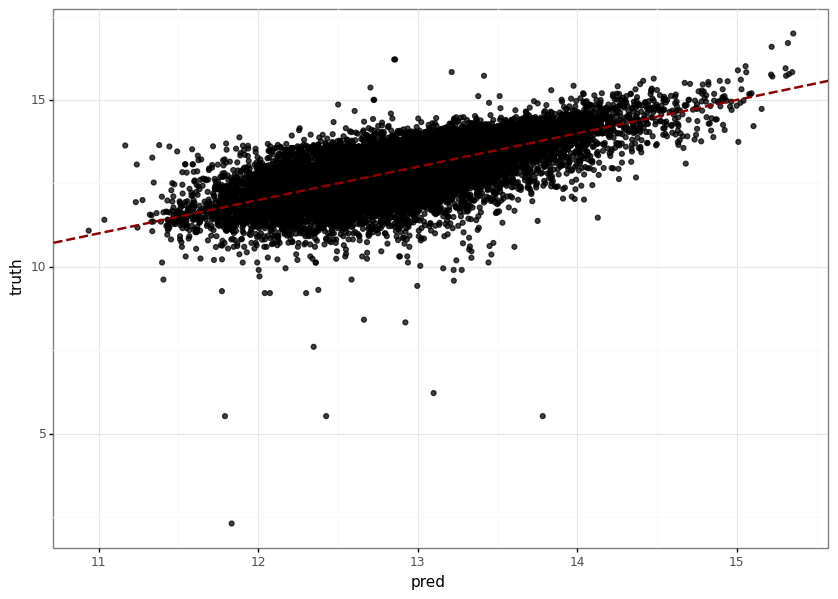

<ggplot: (8789868075749)>

In [28]:
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

## Conclusion

With the additional of several new dummy variables and transforming the renovation data into a calculation of how recently renovated a property is, the model sees a notable improvement from the example provided, with the Mean Squared Error dropping from 0.5 to 0.38 and the R^2 value nearly doubling from 0.24 to 0.47. Graphically, we also observe a tighter fit to the line depicting true and predicted values.